#Project: Recommendation System for Yelp Users
### Aim: The purpose of this project is create a recommendation system  based on user's review text and star ratings for restaurants in Las Vegas with the data provided by Yelp Data Challenge.

### Data: There are 1M reviews, 61K businesses, 10 different cities, over 11 year. <https://www.yelp.com/dataset_challenge/dataset>

### Methods: 
1. Content-based filtering: 
  - A. Mapping restaurants and reviewers into a feature space and compute distance between restaurants and reviwers using dot products. And predict rating with linear model. 
  - B. Mapping review texts into feature space and recommed restaurant with similar text reviews to reviews. (different notebook)
  
  
2. Collaborative filtering: 
  - A. Item-based: Compute similarity between restaurants, recommend restaurants most similar to reviewer's item.
  - B. Model-based: Use restaurant categories to create latent variables in the rating data. Ratings are comoputed by dot products of users & items vectors in the latent feature space.

In [2]:
#import json_to_csv_converter as jc
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from patsy import dmatrix
import seaborn as sb
from matplotlib import pyplot as plt
import recsys.algorithm
%matplotlib inline

#### Data Preprocessing
Convert JSON data to csv files

In [3]:
#business_path = 'yelp_dataset_challenge_academic_dataset 2/yelp_academic_dataset_business.json'
#business_cols = jc.get_superset_of_column_names_from_file(business_path)
#jc.read_and_write_file(business_path, "business.csv", column_names = business_cols)
#review_path = 'yelp_dataset_challenge_academic_dataset 2/yelp_academic_dataset_review.json'
#review_cols = jc.get_superset_of_column_names_from_file(review_path)
#jc.read_and_write_file(review_path, "review.csv", review_cols)
#user_path = 'yelp_dataset_challenge_academic_dataset 2/yelp_academic_dataset_user.json'
#user_cols = jc.get_superset_of_column_names_from_file(user_path)
#jc.read_and_write_file(user_path, "user.csv", user_cols)

Read csv files

In [4]:
business = pd.read_csv("business.csv")
review = pd.read_csv("review.csv")
user = pd.read_csv("user.csv")

/Users/xftim/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (1,4,7,14,18,21,27,30,43,49,52,62,64,66,70,84,89,92,100) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [5]:
print len(business)
print len(review)
print len(user)

61184
1037488
366715


The business dataset contains 61K observations, the review dataset contains 1M observarions, and the user dataset contains 36 observations.

In [6]:
#business.columns.tolist()
#business['categories'].unique()
#business.city.unique()

Extract 'city','categories','business_id', and 'name' from business dataset. Choose restaurants that are only in Las Vegas.

In [7]:
business_df = business[['city','categories','business_id', 'name']]
business_df = business_df[(business_df['city'] == 'Las Vegas')]
ind = []
for i in range(0, len(business_df.categories)):
    if 'Food' in business_df[i:i+1].categories.to_string() or 'Restaurants' in business_df[i:i+1].categories.to_string():
        ind.append(i)      

rest = business_df.iloc[ind]

In [8]:
rest.head(2)

,city,categories,business_id,name
6856,Las Vegas,"['Wine Bars', 'Bars', 'Restaurants', 'Nightlif...",_SM8UKIwBNbmj1r629ipoQ,Chianti Cafe
7111,Las Vegas,"['Pizza', 'Restaurants']",AgtFQVxo-PGQVsOdY6Nvdg,Pizza Hut


Extract 'user_id','stars','business_id' from review dataset. 

In [9]:
review.head(2)

,user_id,review_id,text,votes.cool,business_id,votes.funny,stars,date,type,votes.useful
0,Xqd0DzHaiyRqVH3WRG7hzg,15SdjuK7DmYqUAj6rjGowg,dr. goldberg offers everything i look for in a...,1,vcNAWiLM4dR7D2nwwJ7nCA,0,5,2007-05-17,review,2
1,H1kH6QZV7Le4zqTRNxoZow,RF6UnRTtG7tWMcrO2GEoAg,"Unfortunately, the frustration of being Dr. Go...",0,vcNAWiLM4dR7D2nwwJ7nCA,0,2,2010-03-22,review,2


In [10]:
rvws = review[['user_id','stars','business_id']]

Merge business dataset and review dataset on the buiness id. 

In [11]:
rest_rvws = pd.merge(rest, rvws, on = 'business_id')
rest_rvws.head(2)

,city,categories,business_id,name,user_id,stars
0,Las Vegas,"['Wine Bars', 'Bars', 'Restaurants', 'Nightlif...",_SM8UKIwBNbmj1r629ipoQ,Chianti Cafe,RZwkUvViHYEh5Z65--cVZw,4
1,Las Vegas,"['Wine Bars', 'Bars', 'Restaurants', 'Nightlif...",_SM8UKIwBNbmj1r629ipoQ,Chianti Cafe,mW0l2ZhDeAAgjXPz_x2qRQ,4


#### Data Exploration

In [12]:
for col in rest_rvws:
    print "%-20s: %7d uniques" % (col, rest_rvws[col].nunique())

city                :       1 uniques
categories          :     448 uniques
business_id         :    2539 uniques
name                :    1706 uniques
user_id             :   77840 uniques
stars               :       5 uniques


In [13]:
len(rest_rvws)

190789

In [14]:
n_reviews = rest_rvws.groupby(['name', 'user_id']).stars.nunique()
n_reviews.value_counts()

1    181404
2      2770
3       152
4         7
5         1
dtype: int64

The dataset contains:
- 2539 restaurants.
- 1706 restaurants names, many might be franchise.
- Highest rating with 5 stars
- 77840 reviewers

Since franchise is likely to serve the same food and some properties, we use restaurant name instead of business IDs.

There are:
- 190789 observations

The reviewers might have muliple reviews for a restaurant, so we take the average ratings.



The distribution of ratings:

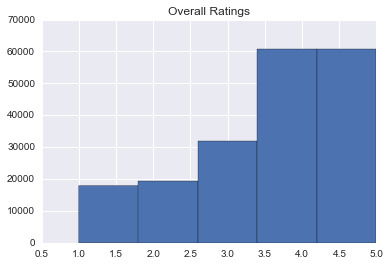

In [15]:
f = rest_rvws.stars.hist(bins=5)
f = plt.title("Overall Ratings")

###Content-Based Flitering

Content-based filtering focus on the properties of items. Similarity of items is measured based on similarity of their properties.[MMD, Leskoves]
Restaurant catorgeries (Wine Bars, Bars, Pizza, Italian, etc.) are used to map as features of the restaurants.  

In [16]:
print rest_rvws.categories[2:3].tolist()
print rest_rvws.categories[9:10].tolist()

["['Wine Bars', 'Bars', 'Restaurants', 'Nightlife', 'Italian']"]
["['Pizza', 'Restaurants']"]


In [17]:
max_features = 5000
cv = CountVectorizer(max_features=max_features)
X_cag = cv.fit_transform(rest_rvws.categories)

In [18]:
X = np.hstack([X_cag.toarray()])
y = rest_rvws.stars
n_samples, n_features = X.shape
print X.shape

(190789, 197)


#### Dot-product method

First, we use the index of first occurance restaurant for its repressenation. Then, give its features same score as the ratings and then average all ratings per user to get a user profile. Each rating is subtracted by 3, so bad ratings are negative and good ratings are postive.  

In [19]:
uniques, idx = np.unique(rest_rvws.name, return_index=True)
rest_features = pd.DataFrame(X[idx, :], index=rest_rvws.name[idx])
print rest_features.shape
rest_features.head(2)

(1706, 197)


,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
name,,,,,,,,,,,,,,,,,,,,,
168 Market,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3 Tomatoes and A Mozzarella,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
reviewer_features = pd.DataFrame(X * (rest_rvws.stars.values - 3).reshape(n_samples, 1))
reviewer_features['user_id'] = rest_rvws.user_id
reviewer_features = reviewer_features.groupby('user_id')[range(n_features)].mean()
reviewer_features = reviewer_features.divide(reviewer_features.sum(axis=1), axis=0)
reviewer_features.head(2)

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
user_id,,,,,,,,,,,,,,,,,,,,,
--2QZsyXGz1OhiD4-0FQLQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0,0
--4fX3LBeXoE88gDTK6TKQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.153846,0,0


In [21]:
len(reviewer_features)

77840

In [22]:
reviewer_features.head(2)

,0,1,2,3,4,5,6,7,8,9,...,187,188,189,190,191,192,193,194,195,196
user_id,,,,,,,,,,,,,,,,,,,,,
--2QZsyXGz1OhiD4-0FQLQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.000000,0,0
--4fX3LBeXoE88gDTK6TKQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.153846,0,0


Now, add a user's ratings for each of the beer's features by taking the dot product of user vector and restaurant vector. 

In [23]:
user = "RZwkUvViHYEh5Z65--cVZw"

In [24]:
my_rvs = rest_rvws[rest_rvws.user_id == user].groupby('name').stars.mean()\
    .sort(ascending=False, inplace=False)
my_rvs

name
White Cross Drugs                  5
Pamplemousse Le Restaurant         5
Albinas Italian American Bakery    5
Swiss Cafe Restaurant              4
Spago                              4
Samosa Factory                     4
India Oven                         4
Ichiza                             4
Go Raw Cafe                        4
Chianti Cafe                       4
Baladie Café                       4
Bonjour Bakery & Deli              3
Amena Bakery & Deli                3
Tamba                              2
Sababa                             2
Name: stars, dtype: int64

In [25]:
v = reviewer_features.loc[user].values
Mx = rest_features.values
pred = Mx.dot(v)
pred = pd.Series(pred, index=rest_features.index, name="predictions").sort(ascending=False, inplace=False)
pred[:20]

name
Big Dog's Bar and Grill              0.540541
Kabob Palace                         0.540541
Little Bangkok Thai Restaurant       0.513514
Sakun Thai                           0.513514
Thai Spice                           0.513514
Go Raw Cafe                          0.513514
Jean Philippe Patisserie             0.486486
Auntie Anne's                        0.486486
Dick's Last Resort                   0.486486
Sesame House                         0.486486
Josette's Bistro                     0.486486
Baba's Tsi-bugan Restaurant          0.486486
Gordon Biersch Brewery Restaurant    0.486486
Grape Street                         0.486486
Nora's Wine Bar and Osteria          0.486486
Chianti Cafe                         0.486486
Fiamma Trattoria & Bar               0.486486
D Vino                               0.486486
Tintoretto Restaurant and Bakery     0.459459
Fin                                  0.459459
Name: predictions, dtype: float64

#### LInear Model:

In [26]:
idx = (rest_rvws.user_id == user).values  # filter reviews of user
X_user, y_user = X[idx, :], y[idx]
 
model = Ridge()
model.fit(X_user, y_user)

uniques, idx = np.unique(rest_rvws.name, return_index=True)
pred = pd.Series(model.predict(X[idx, :]), rest_rvws.name[idx], name="predictions") \
    .sort(ascending=False, inplace=False)
pred[:10]

name
Red Velvet Cafe          4.662425
Sandbar                  4.540951
My Buddy's Greek Cafe    4.485396
Palio Pronto             4.475701
Cafe Belle Madeleine     4.475701
Picasso                  4.471745
Elysium Internet Cafe    4.463551
Studio Café              4.456188
Sidewalk Cafe            4.456188
Grand Café               4.456188
Name: predictions, dtype: float64

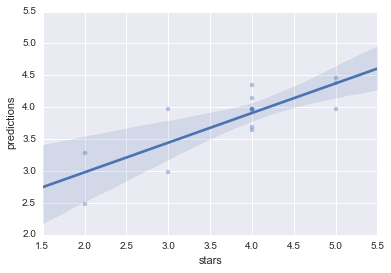

In [27]:
f = sb.regplot(my_rvs, pred[list(my_rvs.index)], scatter_kws=dict(alpha=.4))

### Item-Based Collaborative filtering

Item based filtering make recommendation based on similar items that the user had already rated highly. It is a "because you liked this, we think you'd also like this" approach.

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances

First, creat a pivot table using the name as row and user IDs as columns aggregating the average of stars by user IDs.

In [37]:
pt = pd.pivot_table(rest_rvws, values=["stars"],
        index=["name", "user_id"], aggfunc=np.mean).unstack()

In [38]:
print pt.shape

(1706, 77840)


In [39]:
pt.ix[:5,:5]

stars                         \
user_id                     --2QZsyXGz1OhiD4-0FQLQ --4fX3LBeXoE88gDTK6TKQ   
name                                                                        
168 Market                                     NaN                    NaN   
3 Tomatoes and A Mozzarella                    NaN                    NaN   
360 Gourmet Burrito                            NaN                    NaN   
50's Diner                                     NaN                    NaN   
7- Eleven                                      NaN                    NaN   

                                                                           \
user_id                     --52YqcuRttZN62TCKQdbw --BnK7rx64Gu9KAb2OjMxQ   
name                                                                        
168 Market                                     NaN                    NaN   
3 Tomatoes and A Mozzarella                    NaN                    NaN   
360 Gourmet Burrito                            NaN                    NaN   
50's Diner                                     NaN                    NaN   
7- Eleven                                      NaN                    NaN   

                                                    
user_id                     --D6B8SF9EAIaS4O7wLVJw  
name                                                
168 Market                                     NaN  
3 Tomatoes and A Mozzarella                    NaN  
360 Gourmet Burrito                            NaN  
50's Diner                                     NaN  
7- Eleven                                      NaN

Then, fill the missing values with 0 and measure the similarity based on the cosine distance between all beers.

In [42]:
pt = pt.fillna(0)
dist = cosine_similarity(pt)
dists = pd.DataFrame(dist, columns=pt.index, index = pt.index)

In [43]:
dists.ix[:5,:5]

name,168 Market,3 Tomatoes and A Mozzarella,360 Gourmet Burrito,50's Diner,7- Eleven
name,,,,,
168 Market,1.000000,0.013561,0.010126,0,0
3 Tomatoes and A Mozzarella,0.013561,1.000000,0.015557,0,0
360 Gourmet Burrito,0.010126,0.015557,1.000000,0,0
50's Diner,0.000000,0.000000,0.000000,1,0
7- Eleven,0.000000,0.000000,0.000000,0,1


In [44]:
def get_similar(rests, n = None):
    """
    Return most similar restaurants excluding restaurants provided.  
    
    Paramters:
    rests: list of restaurants. 
    
    Returns:
    ranked_rests: list of rank-ordered restaurants.
    
    """
    rests = [rest for rest in rests if rest in dists.columns]
    rests_summed = dists[rests].apply(lambda row: np.sum(row), axis = 1)
    rests_summed = rests_summed.order(ascending = False)
    ranked_rests = rests_summed.index[rests_summed.index.isin(rests) ==False]
    ranked_rests = ranked_rests.tolist()
    
    if n is None:
        return ranked_rests
    else:
        return ranked_rests[:n]

In [45]:
def recommend_rests(user):
    """
    Return 10 restaurants with most similarity based on users highest rated restaurants.
    
    Parameter:
    user: user_id in yelp dataset.
    
    Returns:
    get_similar: 10 most similar restaurants.
    """
    user_data = rest_rvws[rest_rvws.user_id == user]
    top_rated = user_data[user_data.stars >= 4]
    top_rests = top_rated.name.tolist()
    return get_similar(top_rests, 10)

In [46]:
recommend_rests(user)

['Bonjour Bakery & Deli',
 "Marie Callender's",
 'Sai India Curry',
 "Kitty's Cafe",
 'Jalapeno Grill',
 'Diho Supermarket',
 'China Mama Restaurant',
 'Red Robin',
 'Taqueria Los Parados',
 'Whole Foods Market']

####Model-based collaborative filtering

In Model-based collabrative filtering, both items and users parameters are estimated simultaneouly. First,the rating matrix is decomposed by SVD to reduce the demensionalty and extract latent variables. Then, both user and items are represented in term of these latent variables. Item vector characteristic of given features and user vector represent the preferences for a given feature. Rating are the sum of user vector and item vector by taking their dot products.

In [2]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [3]:
M = rest_rvws.groupby(['name', 'user_id']).stars.mean().unstack()
M = np.maximum(-1, (M - 3).fillna(0) / 2.)
M.head(2)

NameError: name 'rest_rvws' is not defined

In [ ]:
n_components = 500
svd = TruncatedSVD(n_components)
X_red = svd.fit_transform(M.T)
explained_variance = svd.explained_variance_ratio_.sum()
print "Explained variance of the SVD step: %d%%" % (explained_variance * 100)
print "Dimensions feature matrix (old):", M.T.shape
print "Dimensions feature matrix (new):", X_red.shape

In [ ]:
plt.plot(svd.explained_variance_ratio_.cumsum())
f = plt.ylim(0,1)

In [1]:
rests = M.index
top_rests = 10
n_rows, n_cols = 3,2
top_components = n_rows * n_cols
f, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))
for no, component in enumerate(svd.components_[:top_components]):
    ax = axes[no / n_cols][no % n_cols]
    s = pd.Series(svd.components_[no], index = M.index ).sort(inplace=False)[-top_rests:]
    s.plot(kind='barh', ax=ax, title="Component %d\nexplained variance %4.1f" % 
           (no, 100 * svd.explained_variance_ratio_[no]))
f = plt.tight_layout()

NameError: name 'M' is not defined

In [319]:
X_red

array([[  2.04706071e-04,  -1.38809937e-03,  -9.97562589e-04, ...,
          1.83006334e-03,  -1.59069820e-03,   3.15138415e-03],
       [  1.81189426e-02,   5.75630107e-02,  -1.67737417e-02, ...,
         -5.44278359e-02,  -5.97641793e-02,   9.06548760e-02],
       [  7.43100920e-04,   4.41135333e-03,  -4.98280389e-04, ...,
         -1.16218049e-03,  -9.76919124e-03,  -5.55639590e-03],
       ..., 
       [  1.07686131e-01,   4.02881450e-01,   8.53906346e-01, ...,
         -9.68627903e-05,  -6.95821275e-04,  -1.24256523e-04],
       [  6.78265182e-04,   9.90467787e-04,  -9.66570441e-04, ...,
          5.27477452e-03,   5.05580666e-03,   1.14586833e-03],
       [  9.75023394e-01,  -2.22655997e-01,  -4.04421662e-02, ...,
         -1.69218458e-03,  -9.68298307e-04,  -3.42585586e-05]])

In [57]:
userid = list(M.columns).index(user)
rest_recs = X_red[userid].dot(svd.components_)
rest_recs = pd.Series(rest_recs, index=M.index).sort(ascending = False, inplace=False)
rest_recs[:10]

name
Pamplemousse Le Restaurant    0.972926
Go Raw Cafe                   0.508439
Spago                         0.505901
Samosa Factory                0.504681
Baladie Café                  0.504628
Ichiza                        0.502571
El Pollo Loco                 0.064086
Sushiko                       0.061469
Binion's Hotel & Casino       0.057244
Rincon De Buenos Aires        0.053358
dtype: float64